In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir='/content/drive/MyDrive/UCMerced_LandUse/Images'
print(data_dir)

/content/drive/MyDrive/UCMerced_LandUse/Images


In [ ]:
# Constants
IMG_SIZE = (224, 224)
DATASET_PATH = data_dir  # Replace with your dataset path

# Load Dataset
def load_dataset(dataset_path, img_size):
    images = []
    labels = []
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                img = load_img(img_path, target_size=img_size)
                img = img_to_array(img)
                images.append(img)
                labels.append(category)
    return np.array(images), np.array(labels)

print("Loading dataset...")
images, labels = load_dataset(DATASET_PATH, IMG_SIZE)
print(f"Loaded {len(images)} images.")

Loading dataset...
Loaded 2110 images.


In [ ]:
# Encode Labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)


In [ ]:
# Pre-trained Models
vgg16 = VGG16(weights="imagenet", include_top=False, pooling="avg", input_shape=IMG_SIZE + (3,))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
resnet50 = ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=IMG_SIZE + (3,))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Feature Extraction
def extract_features(model, data, preprocess_fn):
    features = []
    for img in data:
        img = preprocess_fn(np.expand_dims(img, axis=0))
        feature = model.predict(img, verbose=0)
        features.append(feature.flatten())
    return np.array(features)

In [ ]:
print("Extracting VGG16 features...")
X_train_vgg = extract_features(vgg16, X_train, preprocess_vgg)
X_test_vgg = extract_features(vgg16, X_test, preprocess_vgg)

Extracting VGG16 features...


In [ ]:
print("Extracting ResNet50 features...")
X_train_resnet = extract_features(resnet50, X_train, preprocess_resnet)
X_test_resnet = extract_features(resnet50, X_test, preprocess_resnet)

Extracting ResNet50 features...


In [ ]:
# Standardize Features
scaler = StandardScaler()
X_train_vgg = scaler.fit_transform(X_train_vgg)
X_test_vgg = scaler.transform(X_test_vgg)
X_train_resnet = scaler.fit_transform(X_train_resnet)
X_test_resnet = scaler.transform(X_test_resnet)

In [ ]:

# Train SVM Classifier
def train_and_evaluate(X_train, y_train, X_test, y_test, model_name):
    svm = SVC(kernel="linear", random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy * 100:.2f}%")
    cm = confusion_matrix(y_test, y_pred)
    display_confusion_matrix(cm, model_name, label_encoder.classes_)
    return svm


In [ ]:
def display_confusion_matrix(cm, model_name, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

Training SVM on VGG16 features...
VGG16 Accuracy: 93.60%


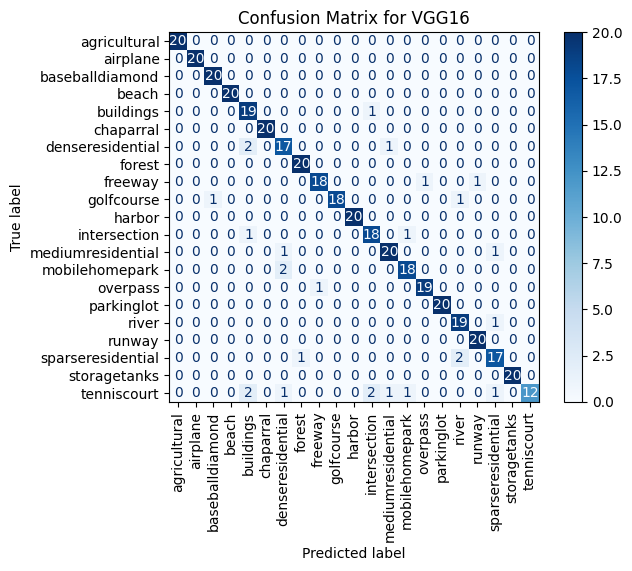

Training SVM on ResNet50 features...
ResNet50 Accuracy: 94.31%


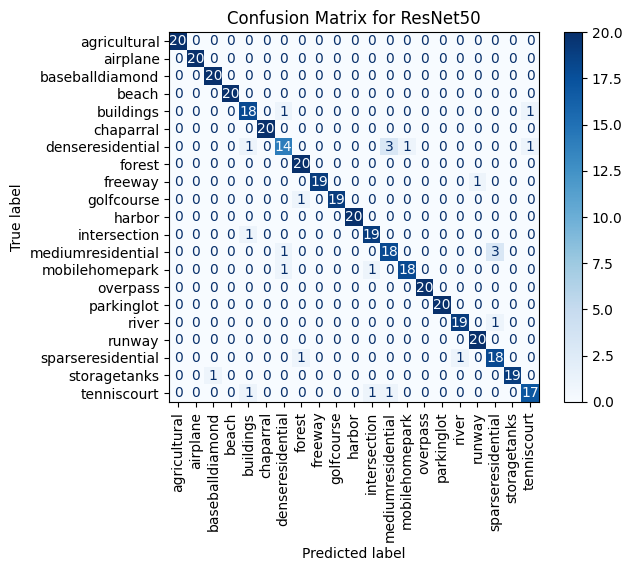

In [ ]:
print("Training SVM on VGG16 features...")
svm_vgg = train_and_evaluate(X_train_vgg, y_train, X_test_vgg, y_test, "VGG16")

print("Training SVM on ResNet50 features...")
svm_resnet = train_and_evaluate(X_train_resnet, y_train, X_test_resnet, y_test, "ResNet50")